## Import modules

In [152]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import numpy as np 
import xarray as xr 
import yaml
from yaml import CLoader as Loader, CDumper as Dumper
from pathlib import Path
import os
import glob
import pandas as pd

import sys
sys.path.append("Y:\\Philip\\PyDDM\\PyDDM") #must point to the PyDDM folder
import ddm_analysis_and_fitting as ddm

import gc
import statistics

import importlib
importlib.reload(ddm)

<module 'ddm_analysis_and_fitting' from 'Y:\\Philip\\PyDDM\\PyDDM\\ddm_analysis_and_fitting.py'>

## Gather tau and q from every roi

In [223]:
tau_dict = {}
q_dict = {}

location = 'Y:\\Philip\\Nat\\0.3apo'
time_locations = glob.glob(location+"\\*min")
#print(time_locations)
diffusion_data = {}
for times_dir in time_locations:
    print("Directory: %s" % times_dir)
    the_time = times_dir.split("\\")[-1]
    tau_dict[the_time] = {}
    q_dict[the_time] = {}
    print("Analyzing time: %s" % the_time)
    ISF_files = glob.glob('%s\\*)\\*.nc' % times_dir)
    for i,files in enumerate(ISF_files):
        tau_dict[the_time][files]={}
        q_dict[the_time][files]={}
        stuff = xr.load_dataset(files)
        tau_dict[the_time][files]=stuff.parameters.loc['Tau']
        q_dict[the_time][files]=stuff.q

Directory: Y:\Philip\Nat\0.3apo\0min
Analyzing time: 0min
Directory: Y:\Philip\Nat\0.3apo\100min
Analyzing time: 100min
Directory: Y:\Philip\Nat\0.3apo\10min
Analyzing time: 10min
Directory: Y:\Philip\Nat\0.3apo\110min
Analyzing time: 110min
Directory: Y:\Philip\Nat\0.3apo\120min
Analyzing time: 120min
Directory: Y:\Philip\Nat\0.3apo\130min
Analyzing time: 130min
Directory: Y:\Philip\Nat\0.3apo\140min
Analyzing time: 140min
Directory: Y:\Philip\Nat\0.3apo\150min
Analyzing time: 150min
Directory: Y:\Philip\Nat\0.3apo\160min
Analyzing time: 160min
Directory: Y:\Philip\Nat\0.3apo\170min
Analyzing time: 170min
Directory: Y:\Philip\Nat\0.3apo\180min
Analyzing time: 180min
Directory: Y:\Philip\Nat\0.3apo\190min
Analyzing time: 190min
Directory: Y:\Philip\Nat\0.3apo\200min
Analyzing time: 200min
Directory: Y:\Philip\Nat\0.3apo\20min
Analyzing time: 20min
Directory: Y:\Philip\Nat\0.3apo\210min
Analyzing time: 210min
Directory: Y:\Philip\Nat\0.3apo\220min
Analyzing time: 220min
Directory: Y:\Ph

## Examine timepoint

<IPython.core.display.Javascript object>


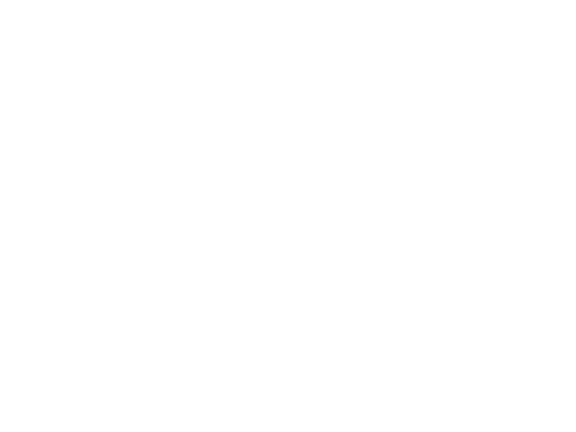

In [224]:
timey = '240min'

%matplotlib notebook

for i, files in enumerate(q_dict[timey]):
    #plt.figure()
    plt.xlabel('q (um-1)')
    plt.ylabel('tau (s)')
    plt.loglog(q_dict[timey][files], tau_dict[timey][files], 'ro', alpha = 0.1)
    plt.loglog(q_dict[timey][files][3], tau_dict[timey][files][3], 'bo', alpha = 0.1)
    plt.loglog(q_dict[timey][files][13], tau_dict[timey][files][13], 'bo', alpha = 0.1)
        
plt.show()

## Loop over data

In [227]:
master_list = []
master_std = []

for i in range(0,241,10):
    timey = str(i)+'min'
    
    try:
        vals_dict = {}
        lister = []
        
        for files in tau_dict[timey]:
            listy = (tau_dict[timey][files].values.tolist())
            lister.append(listy)
        for n, lists in enumerate(lister):
            vals_dict[n] = {}
            for i in range(len(lists)):
                vals_dict[n][i] = {}
                vals_dict[n][i] = lists[i]

        tau_avg_list = []
        std_list = []

        for w in range(64):
            num_list = []
            for z in range(len(lister)):
                num = vals_dict[z][w]
                num_list.append(num)
            final = sum(num_list)/len(num_list)   #MEAN
            std = np.std(num_list)
            #final = statistics.median(num_list)    #MEDIAN
            std_list.append(std)
            tau_avg_list.append(final)


        vals_dict = {}
        lister = []

        for files in q_dict[timey]:
            listy = (q_dict[timey][files].values.tolist())
            lister.append(listy)
        for n, lists in enumerate(lister):
            vals_dict[n] = {}
            for i in range(len(lists)):
                vals_dict[n][i] = {}
                vals_dict[n][i] = lists[i]


        q_avg_list = []

        for w in range(64):
            num_list = []
            for z in range(75):
                num = vals_dict[z][w]
                num_list.append(num)
            final = sum(num_list)/len(num_list)
            q_avg_list.append(final)
            
    except:
        tau_avg_list = []
        q_avg_list = []
        std_list = []
        for w in range(64):
            final = [0]
            tau_avg_list.append(final)
            std_list.append(final)
            q_avg_list.append(final)
    
    master_list.append(tau_avg_list)
    master_std.append(std_list)

#print(master_list)
#print(master_std)

df = pd.DataFrame(q_avg_list)
df2 =  pd.DataFrame(master_list)
df3 = pd.DataFrame(master_std)

df.T.to_csv(location+'\\df.csv', index=False)
df2.T.to_csv(location+'\\df.csv', index=False, mode='a')
df3.T.to_csv(location+'\\df.csv', index=False, mode='a')

#creates data frame:
#q_list (64)
#tau_lists (25)
#std_lists (25)

<IPython.core.display.Javascript object>


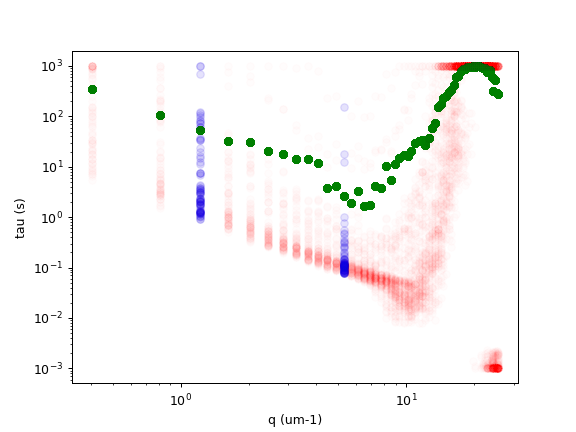

In [228]:
timey = '240min'
timex = int(int(timey.replace('min',''))/10)

%matplotlib notebook

for i, files in enumerate(q_dict[timey]):

    #plt.figure()
    plt.xlabel('q (um-1)')
    plt.ylabel('tau (s)')
    plt.loglog(q_dict[timey][files], tau_dict[timey][files], 'ro', alpha = 0.01)
    plt.loglog(q_dict[timey][files][3], tau_dict[timey][files][3], 'bo', alpha = 0.1)
    plt.loglog(q_dict[timey][files][13], tau_dict[timey][files][13], 'bo', alpha = 0.1)
    plt.loglog(q_dict[timey][files], master_list[timex], 'go', alpha = 0.1)
    
plt.show()

In [151]:
D_list = []
std_list = []

for i in range(0,241,10):
    timey = str(i)+'min'
    timex = int(int(timey.replace('min',''))/10)
    for i, files in enumerate(q_dict[timey]):
        D = 1/(master_list[timex][4:12]*q_dict[timey][files][4:12]**2)
    aaa = D.mean()
    bbb = D.std()
    D_list.append(aaa)
    std_list.append(bbb)
print(D_list)
print(std_list)

[<xarray.DataArray 'q' ()>
array(0.66308833), <xarray.DataArray 'q' ()>
array(0.54486112), <xarray.DataArray 'q' ()>
array(0.49202654), <xarray.DataArray 'q' ()>
array(0.24504121), <xarray.DataArray 'q' ()>
array(0.21245441), <xarray.DataArray 'q' ()>
array(0.21245441), <xarray.DataArray 'q' ()>
array(0.36311313), <xarray.DataArray 'q' ()>
array(0.37149192), <xarray.DataArray 'q' ()>
array(0.32648952), <xarray.DataArray 'q' ()>
array(0.3316721), <xarray.DataArray 'q' ()>
array(0.32541452), <xarray.DataArray 'q' ()>
array(0.33284668), <xarray.DataArray 'q' ()>
array(0.29969988), <xarray.DataArray 'q' ()>
array(0.29182559), <xarray.DataArray 'q' ()>
array(0.26143506), <xarray.DataArray 'q' ()>
array(0.24825827), <xarray.DataArray 'q' ()>
array(0.26805112), <xarray.DataArray 'q' ()>
array(0.20396599), <xarray.DataArray 'q' ()>
array(0.2239078), <xarray.DataArray 'q' ()>
array(0.23699878), <xarray.DataArray 'q' ()>
array(0.2953179), <xarray.DataArray 'q' ()>
array(0.22740879), <xarray.Data

AttributeError: 'list' object has no attribute 'value'

In [ ]:
%matplotlib notebook

plt.loglog(q, tau, 'ro')
plt.loglog(q[13], tau[13], 'bo')
plt.axhline(1/20)
D = 1/(tau[3:13]*q[3:13]**2)
plt.xlabel('q')
plt.ylabel('tau')
print(D.mean())
print(D.std())

plt.loglog(q,1/(D.mean()*q**2))